# Interpolating Spectra Data and Fitting with DRDMannTurb

In [1]:
import numpy as np 
import csv
from pathlib import Path 
import torch 
import torch.nn as nn

from drdmannturb.calibration import CalibrationProblem
from drdmannturb.interpolation import extract_x_spectra, interp_spectra
from drdmannturb.data_generator import OnePointSpectraDataGenerator
from drdmannturb.shared.parameters import NNParameters, ProblemParameters, LossParameters, PhysicalParameters
from drdmannturb.shared.enums import DataType

import matplotlib as mpl 
import matplotlib.pyplot as plt
mpl.style.use('seaborn')

device = "cuda" if torch.cuda.is_available() else "cpu" 

# v2: torch.set_default_device('cuda:0')
if torch.cuda.is_available():
    torch.set_default_tensor_type("torch.cuda.FloatTensor")

/tmp/ipykernel_50167/1983873178.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn')


## Extract Data from Provided CSVs

In [2]:
# for interpolation, log10-scaled k1 is used, regular values of the domain used for fitting
x_coords_u, u_spectra = extract_x_spectra(Path().resolve() /"data" / "u_spectra.csv")
x_coords_v, v_spectra = extract_x_spectra(Path().resolve() /"data" / "v_spectra.csv")
x_coords_w, w_spectra = extract_x_spectra(Path().resolve() /"data" / "w_spectra.csv")
x_coords_uw, uw_cospectra = extract_x_spectra(Path().resolve() /"data" / "uw_cospectra.csv")


In [3]:
x_interp = np.linspace(min(x_coords_w), max(x_coords_w), 40) # all coords are on the same here, but choose bounds on the domain which are inclusive of all sampling locations

interp_u = interp_spectra(x_interp, x_coords_u, u_spectra)
interp_v = interp_spectra(x_interp,x_coords_v, v_spectra)
interp_w = interp_spectra(x_interp, x_coords_w, w_spectra)
interp_uw = interp_spectra(x_interp,x_coords_uw, uw_cospectra)

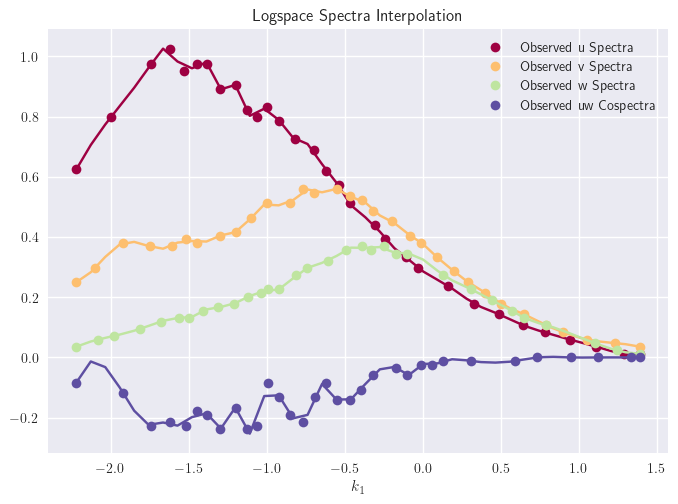

In [4]:
cmap = plt.get_cmap('Spectral', 4)
custom_palette = [mpl.colors.rgb2hex(cmap(i)) for i in range(cmap.N)]

plt.plot(x_coords_u, u_spectra, "o", label="Observed u Spectra", color=custom_palette[0])
plt.plot(x_interp, interp_u, color=custom_palette[0])
plt.plot(x_coords_v, v_spectra, "o", label="Observed v Spectra", color=custom_palette[1])
plt.plot(x_interp, interp_v, color=custom_palette[1])
plt.plot(x_coords_w, w_spectra, "o", label="Observed w Spectra", color=custom_palette[2])
plt.plot(x_interp, interp_w, color=custom_palette[2])
plt.plot(x_coords_uw, uw_cospectra, "o", label="Observed uw Cospectra", color=custom_palette[3])
plt.plot(x_interp, interp_uw, color=custom_palette[3])

plt.xlabel(r"$k_1$")

plt.title("Logspace Spectra Interpolation")
plt.legend()

In [5]:
L = 0.59
Gamma = 3.9
sigma = 3.2
Uref = 21.0 

domain_np = np.power(10, x_interp)
domain = torch.tensor(domain_np)

pb = CalibrationProblem(
    nn_params = NNParameters(
        activations = [nn.GELU(), nn.GELU()], 
    ),
    prob_params = ProblemParameters(nepochs=5),
    loss_params = LossParameters(),
    phys_params = PhysicalParameters(
        L=L,
        Gamma=Gamma,
        sigma=sigma,
        Uref=Uref,
        domain=domain
    ), 
    device=device
)

/home/ai/miniconda3/envs/fracturbulence/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [9]:
parameters = pb.parameters
parameters[:3] = [
    np.log(L),
    np.log(Gamma),
    np.log(sigma)
]

pb.parameters = parameters[:len(pb.parameters)]

f = domain
k1_data_pts = 2 * torch.pi * f / Uref 

DataPoints = [(k1, 1) for k1 in k1_data_pts]
spectra_values = np.stack((interp_u, interp_v, interp_w, -interp_uw), axis=1)

In [11]:
Data = OnePointSpectraDataGenerator(data_points=DataPoints, data_type=DataType.AUTO, k1_data_points=(k1_data_pts.cpu().numpy() if torch.cuda.is_available() else k1_data_pts.numpy()), spectra_values=spectra_values).Data

[fit1] ---------------------
Parameters [3.43825859e+03 1.25524987e+03 1.54627976e+00]
RMSE: 0.0306845781823255
R-squared: 0.9923822120712771
[fit2] ---------------------
Parameters [611.97304606 450.90112098   1.44521432]
RMSE: 0.06655568019186855
R-squared: 0.8362598440331215
[fit3] ---------------------
Parameters [81.57032055 63.73679497  1.8205244 ]
RMSE: 0.021661706943741213
R-squared: 0.9631571380884996
[fit4] ---------------------
Parameters [2.45129452e+02 5.50455730e+04 1.72868911e+00]
RMSE: 0.03302925293012712
R-squared: 0.8525919464352417


In [ ]:
plt.plot()

In [9]:
# pb.eval(k1_data_pts)
# pb.calibrate(data=Data)